## バンドパスフィルタ

In [12]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
def dft(img):
    # prepare DFT coefficient
    G = np.zeros((L, K, channel), dtype=np.complex)
    
    # prepare
    x = np.tile(np.arange(W), (H, 1))
    y = np.arange(H).repeat(W).reshape(H,-1)
    
    # dft
    for c in range(channel):
        for l in range(L):
            for k in range(K):
                G[l, k, c] = np.sum(img[...,c]*np.exp(-2j*np.pi*(x*k/K+y*l/L))) / np.sqrt(K*L)
    
    return G


def idft(G):
    # prepare out image
    out = np.zeros((H, W, C), dtype=np.float32)
    
    # prepare
    x = np.tile(np.arange(W), (H,1))
    y = np.arange(H).repeat(W).reshape(H, -1)
    
    for c in range(channel):
        for l in range(L):
            for k in range(K):
                out[l,k,c] = np.abs(np.sum(G[...,c]*np.exp(2j*np.pi*(x*k/K+y*l/L)))) / np.sqrt(L*K)
                
    out = np.clip(out, 0, 255).astype(np.uint8)

    return out


def hpf(G, ratio1=0.1, ratio2=0.5):
    # temporary G
    _G = np.zeros_like(G)
    
    # transfer positions
    _G[:H//2, :W//2] = G[H//2:, W//2:]
    _G[:H//2, W//2:] = G[H//2:, :W//2]
    _G[H//2:, :W//2] = G[:H//2, W//2:]
    _G[H//2:, W//2:] = G[:H//2, :W//2]
    
    # get distance from center
    x = np.tile(np.arange(W), (H,1))
    y = np.arange(H).repeat(W).reshape(H, -1)
    
    _x = x - W//2
    _y = y - H//2
    
    r = np.sqrt(_x**2+_y**2)
    mask = np.ones((H, W), dtype=np.float32)
    # ここの条件の入れ方あっているだろうか？
    mask[(r<(W//2*ratio1)) | (r>(W//2*ratio2))] =0
    
    # これ忘れてた
    mask = np.repeat(mask, channel).reshape(H, W, C)
    
    # filtering
    _G *= mask
    
    # reverce original positions
    G[:H//2, :W//2] = _G[H//2:, W//2:]
    G[:H//2, W//2:] = _G[H//2:, :W//2]
    G[H//2:, :W//2] = _G[:H//2, W//2:]
    G[H//2:, W//2:] = _G[:H//2, :W//2]
    
    return G



error: OpenCV(4.2.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:661: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'imwrite_'


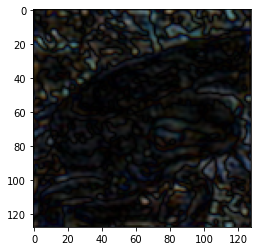

In [16]:
img = cv2.imread('../imori.jpg')
# gray scaleはしないでやってみる

H, W, C = img.shape
K, L, channel = 128, 128, 3

G = dft(img)
G = hpf(G)
out = idft(G)

plt.imshow(out)
cv2.imwrite('out35.ｊｐｇ', out)